In [5]:
import numpy as np
FILE_PATH = "data/FashionMNIST0.6.npz"
dataset = np.load (FILE_PATH)
Xtr = dataset['Xtr']
Str = dataset['Str']
Xts = dataset['Xts']
Yts = dataset['Yts']
print(Xtr.shape)
print(Str.shape)
print(Xts.shape)
print(Yts.shape)

(18000, 784)
(18000,)
(3000, 784)
(3000,)



CIFAR-10 Dataset:
  Training images shape: (15000, 32, 32, 3)
  Training labels shape: (15000,)
  Test images shape: (3000, 32, 32, 3)
  Test labels shape: (3000,)
  Unique classes in training: [0 1 2]
  Unique classes in test: [0 1 2]


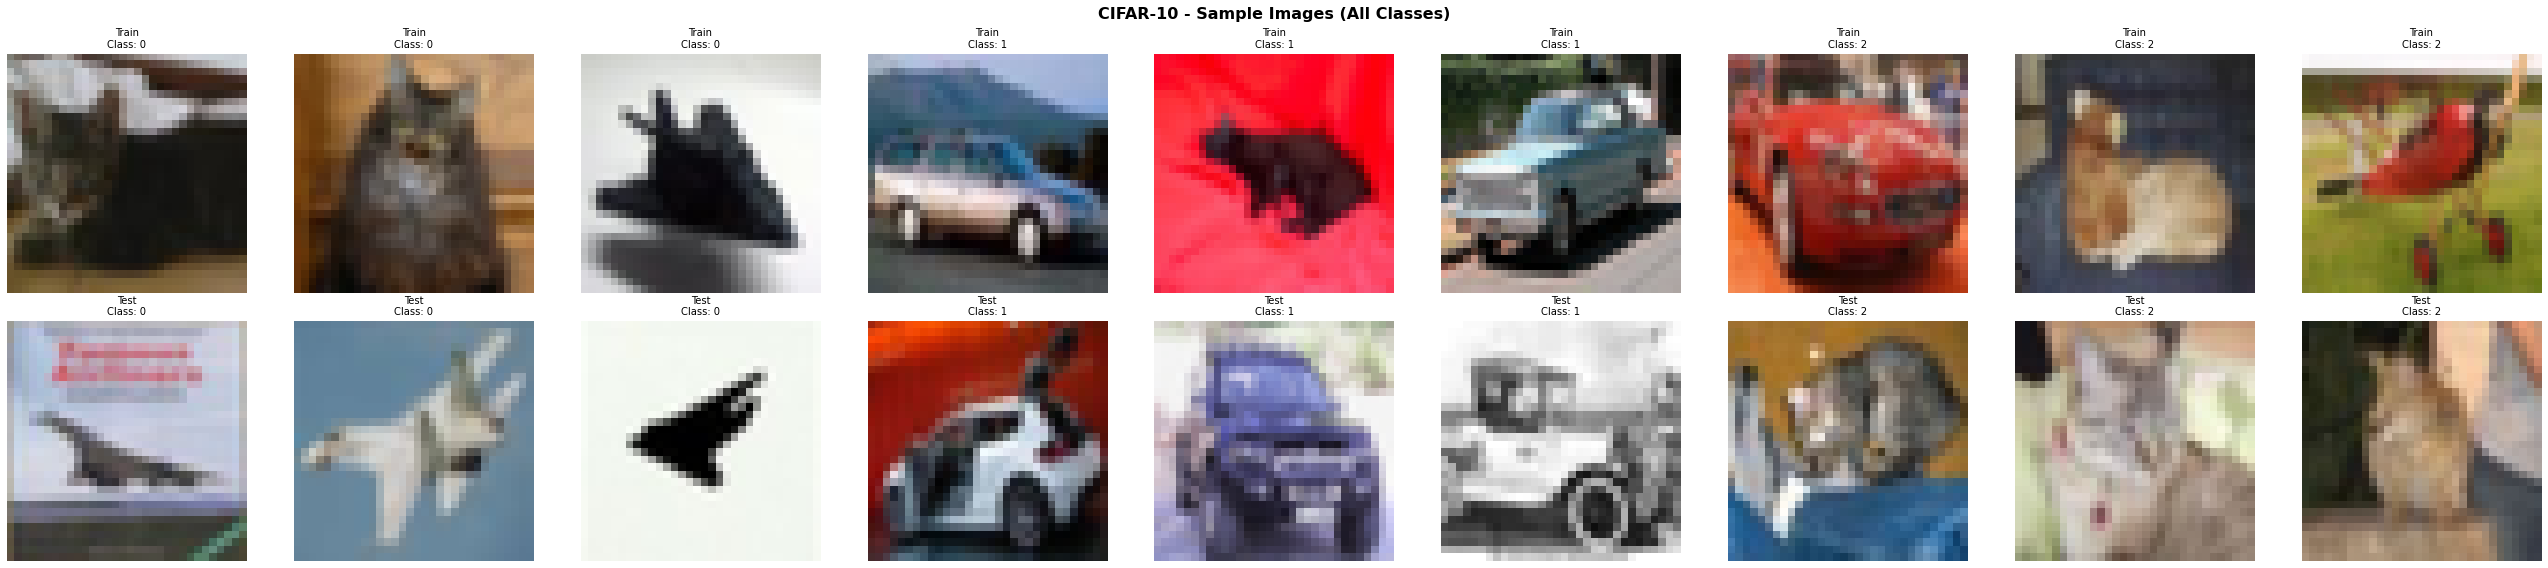


FashionMNIST (30% noise) Dataset:
  Training images shape: (18000, 784)
  Training labels shape: (18000,)
  Test images shape: (3000, 784)
  Test labels shape: (3000,)
  Unique classes in training: [0 1 2]
  Unique classes in test: [0 1 2]


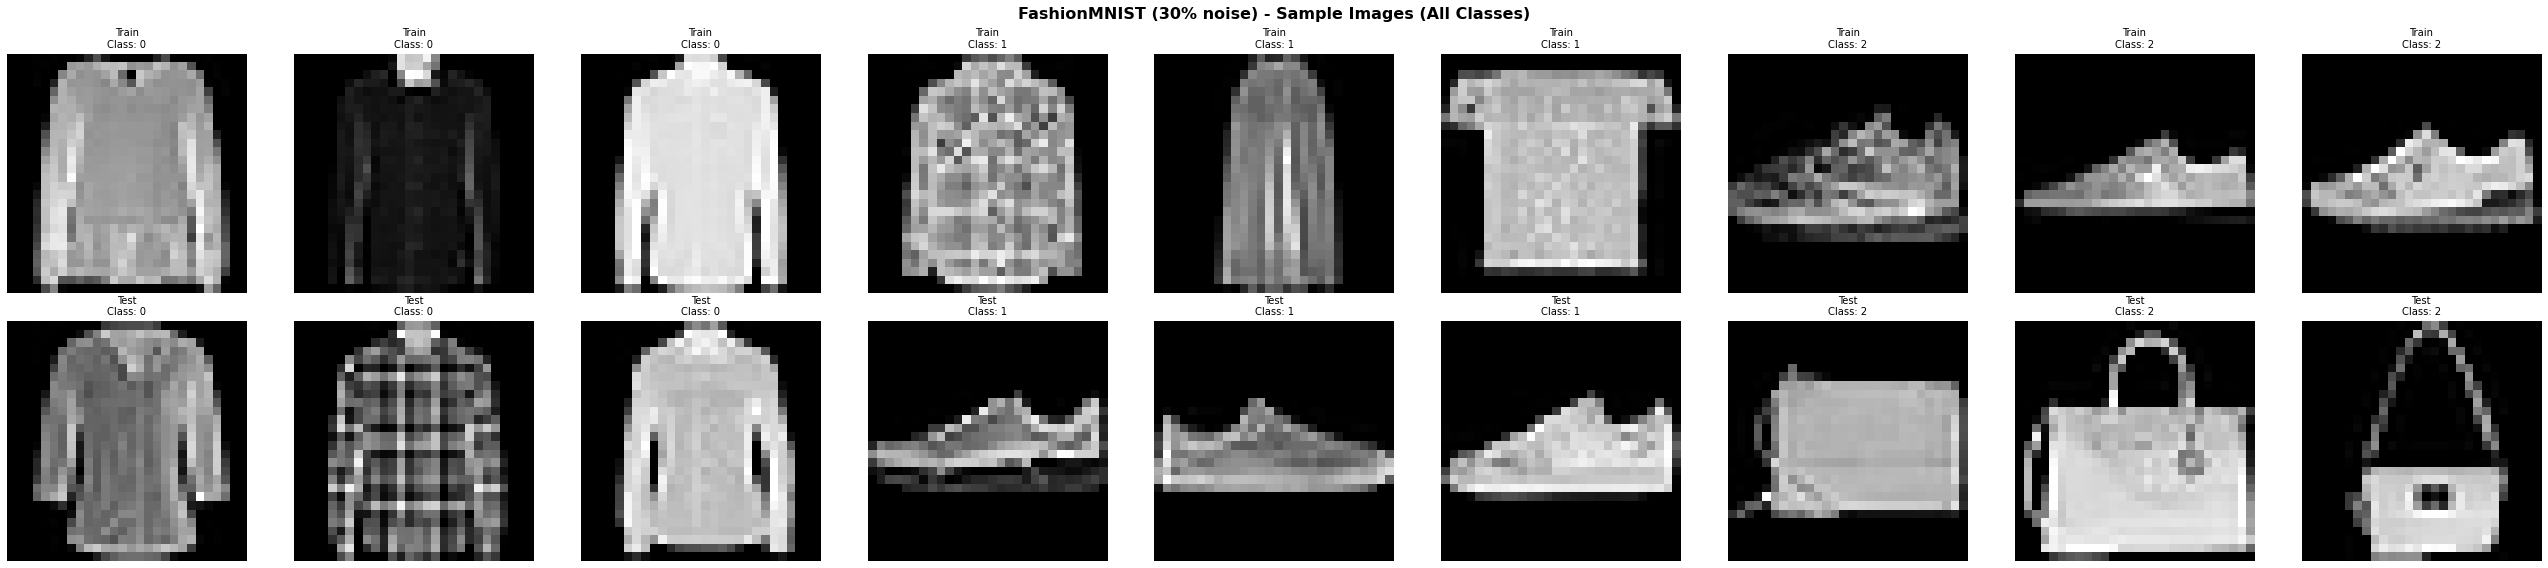


FashionMNIST (60% noise) Dataset:
  Training images shape: (18000, 784)
  Training labels shape: (18000,)
  Test images shape: (3000, 784)
  Test labels shape: (3000,)
  Unique classes in training: [0 1 2]
  Unique classes in test: [0 1 2]


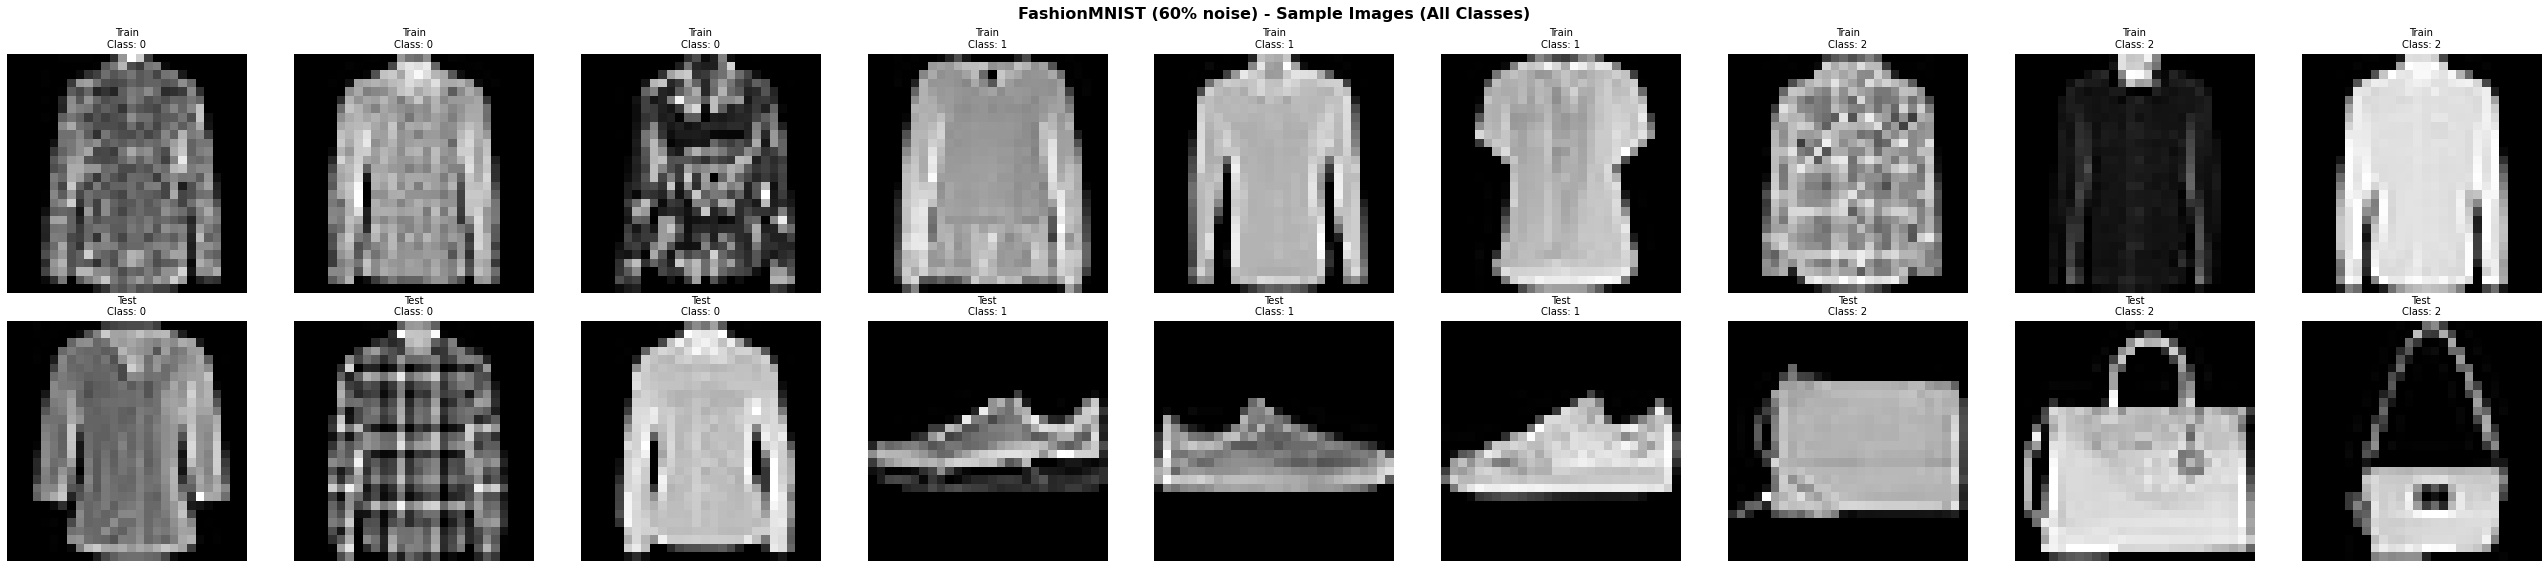

In [8]:
import matplotlib.pyplot as plt

# Function to visualize dataset samples with all classes represented
def visualize_dataset(dataset_path, dataset_name, samples_per_class=3):
    data = np.load(dataset_path)
    
    # Load training and test data
    Xtr = data['Xtr']
    Str = data['Str']
    Xts = data['Xts']
    Yts = data['Yts']
    
    print(f"\n{dataset_name} Dataset:")
    print(f"  Training images shape: {Xtr.shape}")
    print(f"  Training labels shape: {Str.shape}")
    print(f"  Test images shape: {Xts.shape}")
    print(f"  Test labels shape: {Yts.shape}")
    
    # Get unique classes
    train_classes = np.unique(Str)
    test_classes = np.unique(Yts)
    print(f"  Unique classes in training: {train_classes}")
    print(f"  Unique classes in test: {test_classes}")
    
    # Check if images are flattened (e.g., 784 = 28x28)
    is_flattened = len(Xtr.shape) == 2 and Xtr.shape[1] == 784
    
    num_classes = len(train_classes)
    
    # Create figure for visualization
    fig, axes = plt.subplots(2, num_classes * samples_per_class, figsize=(4 * samples_per_class * num_classes, 8))
    fig.suptitle(f'{dataset_name} - Sample Images (All Classes)', fontsize=16, fontweight='bold')
    
    # Helper function to display an image
    def display_image(ax, img, label, row_label):
        if is_flattened:
            img = img.reshape(28, 28)
            ax.imshow(img, cmap='gray')
        elif len(img.shape) == 2 or img.shape[-1] == 1:
            ax.imshow(img.squeeze(), cmap='gray')
        else:
            ax.imshow(img)
        ax.set_title(f'{row_label}\nClass: {label}', fontsize=10)
        ax.axis('off')
    
    # Display training samples (top row) - organized by class
    col_idx = 0
    for class_label in train_classes:
        # Find indices for this class
        class_indices = np.where(Str == class_label)[0]
        # Sample a few images from this class
        sample_indices = class_indices[:samples_per_class]
        
        for idx in sample_indices:
            ax = axes[0, col_idx]
            display_image(ax, Xtr[idx], Str[idx], 'Train')
            col_idx += 1
    
    # Display test samples (bottom row) - organized by class
    col_idx = 0
    for class_label in test_classes:
        # Find indices for this class
        class_indices = np.where(Yts == class_label)[0]
        # Sample a few images from this class
        sample_indices = class_indices[:samples_per_class]
        
        for idx in sample_indices:
            ax = axes[1, col_idx]
            display_image(ax, Xts[idx], Yts[idx], 'Test')
            col_idx += 1
    
    plt.tight_layout()
    plt.show()

# Visualize all three datasets
visualize_dataset("data/CIFAR.npz", "CIFAR-10")
visualize_dataset("data/FashionMNIST0.3.npz", "FashionMNIST (30% noise)")
visualize_dataset("data/FashionMNIST0.6.npz", "FashionMNIST (60% noise)")


In [37]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.models as models
import torchvision.transforms as transforms
from tqdm import tqdm

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Custom Dataset class with normalization for pre-trained models
class CIFARDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        """
        Args:
            images: numpy array of shape (N, 32, 32, 3)
            labels: numpy array of shape (N,)
            transform: optional transform to be applied on images
        """
        # Convert to torch tensors and normalize to [0, 1]
        self.images = torch.FloatTensor(images) / 255.0
        # Permute from (N, H, W, C) to (N, C, H, W) for PyTorch
        self.images = self.images.permute(0, 3, 1, 2)
        self.labels = torch.LongTensor(labels)
        
        # ImageNet normalization for pre-trained models
        self.normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                             std=[0.229, 0.224, 0.225])
    
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        
        # Apply ImageNet normalization
        image = self.normalize(image)
        
        return image, label

# Use pre-trained ResNet18 (standard for CIFAR)
def get_pretrained_model(num_classes=3):
    """
    Load pre-trained ResNet18 and adapt it for CIFAR dataset
    """
    # Load pre-trained ResNet18
    model = models.resnet18(pretrained=True)
    
    # Modify first conv layer for smaller CIFAR images (32x32)
    # Original: Conv2d(3, 64, kernel_size=7, stride=2, padding=3)
    # For CIFAR: use smaller kernel and stride
    model.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
    
    # Remove the first maxpool layer (too aggressive for 32x32 images)
    model.maxpool = nn.Identity()
    
    # Replace the final fully connected layer for our number of classes
    num_features = model.fc.in_features
    model.fc = nn.Linear(num_features, num_classes)
    
    return model

# Training function with tqdm
def train_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    # Add tqdm progress bar
    pbar = tqdm(dataloader, desc='Training', leave=False)
    
    for images, labels in pbar:
        images, labels = images.to(device), labels.to(device)
        
        # Zero the gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward pass and optimize
        loss.backward()
        optimizer.step()
        
        # Statistics
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        # Update progress bar
        current_acc = 100 * correct / total
        pbar.set_postfix({'loss': f'{loss.item():.4f}', 'acc': f'{current_acc:.2f}%'})
    
    epoch_loss = running_loss / len(dataloader)
    epoch_acc = 100 * correct / total
    
    return epoch_loss, epoch_acc

# Evaluation function with tqdm
def evaluate(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    # Add tqdm progress bar
    pbar = tqdm(dataloader, desc='Evaluating', leave=False)
    
    with torch.no_grad():
        for images, labels in pbar:
            images, labels = images.to(device), labels.to(device)
            
            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            # Statistics
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            # Update progress bar
            current_acc = 100 * correct / total
            pbar.set_postfix({'loss': f'{loss.item():.4f}', 'acc': f'{current_acc:.2f}%'})
    
    avg_loss = running_loss / len(dataloader)
    accuracy = 100 * correct / total
    
    return avg_loss, accuracy

# Early Stopping class
class EarlyStopping:
    """Early stops the training if validation accuracy doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=True, delta=0, path='best_cifar_model.pth'):
        """
        Args:
            patience (int): How long to wait after last time validation accuracy improved.
            verbose (bool): If True, prints a message for each validation accuracy improvement.
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
            path (str): Path for the checkpoint to be saved to.
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_acc_max = 0.0  # Track maximum accuracy instead of minimum loss
        self.delta = delta
        self.path = path
        self.best_epoch = 0

    def __call__(self, val_acc, model, epoch):
        """
        Call method to check if early stopping should be triggered.
        
        Args:
            val_acc (float): Current validation accuracy
            model: The model to save
            epoch (int): Current epoch number
        """
        score = val_acc  # Higher accuracy is better

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_acc, model, epoch)
        elif score < self.best_score + self.delta:
            # No improvement
            self.counter += 1
            if self.verbose:
                print(f'  EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            # Improvement detected
            self.best_score = score
            self.save_checkpoint(val_acc, model, epoch)
            self.counter = 0

    def save_checkpoint(self, val_acc, model, epoch):
        '''Saves model when validation accuracy increases.'''
        if self.verbose:
            if self.val_acc_max > 0:
                print(f'  Validation accuracy increased ({self.val_acc_max:.2f}% → {val_acc:.2f}%). Saving model...')
            else:
                print(f'  Saving initial model (Val Acc: {val_acc:.2f}%)...')
        torch.save(model.state_dict(), self.path)
        self.val_acc_max = val_acc
        self.best_epoch = epoch


Using device: cuda


In [38]:
# Load CIFAR dataset
print("Loading CIFAR dataset...")
cifar_data = np.load("data/CIFAR.npz")
X_train = cifar_data['Xtr']
y_train = cifar_data['Str']
X_test = cifar_data['Xts']
y_test = cifar_data['Yts']

print(f"Training set: {X_train.shape}, {y_train.shape}")
print(f"Test set: {X_test.shape}, {y_test.shape}")

# Create datasets and dataloaders
train_dataset = CIFARDataset(X_train, y_train)
test_dataset = CIFARDataset(X_test, y_test)

batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"\nDataLoader info:")
print(f"  Training batches: {len(train_loader)}")
print(f"  Test batches: {len(test_loader)}")

# Initialize pre-trained model
num_classes = len(np.unique(y_train))
print(f"\nLoading pre-trained ResNet18 for {num_classes} classes...")
model = get_pretrained_model(num_classes=num_classes).to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

# Learning rate scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True)

print(f"\nModel: Pre-trained ResNet18 (adapted for CIFAR)")
print(f"Total parameters: {sum(p.numel() for p in model.parameters()):,}")
print(f"Trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")
print("\nModel successfully loaded and ready for training!")


Loading CIFAR dataset...
Training set: (15000, 32, 32, 3), (15000,)
Test set: (3000, 32, 32, 3), (3000,)

DataLoader info:
  Training batches: 235
  Test batches: 47

Loading pre-trained ResNet18 for 3 classes...

Model: Pre-trained ResNet18 (adapted for CIFAR)
Total parameters: 11,170,371
Trainable parameters: 11,170,371

Model successfully loaded and ready for training!


In [39]:
# Training loop (Baseline)
num_epochs = 15
train_losses = []
train_accs = []
test_losses = []
test_accs = []
best_test_acc = 0.0
best_epoch = 0

print("Starting baseline training...")
print("=" * 80)

# Add epoch progress bar
epoch_pbar = tqdm(range(num_epochs), desc='Baseline Training')

for epoch in epoch_pbar:
    # Train
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    
    # Evaluate on test set
    test_loss, test_acc = evaluate(model, test_loader, criterion, device)
    
    # Store metrics
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    test_losses.append(test_loss)
    test_accs.append(test_acc)
    
    # Update epoch progress bar
    epoch_pbar.set_postfix({
        'train_loss': f'{train_loss:.4f}',
        'train_acc': f'{train_acc:.2f}%',
        'test_loss': f'{test_loss:.4f}',
        'test_acc': f'{test_acc:.2f}%'
    })
    
    # Print detailed progress
    print(f"\nEpoch [{epoch+1}/{num_epochs}]")
    print(f"  Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
    print(f"  Test Loss:  {test_loss:.4f}, Test Acc:  {test_acc:.2f}%")
    
    # Save best model based on test accuracy
    if test_acc > best_test_acc:
        best_test_acc = test_acc
        best_epoch = epoch + 1
        torch.save(model.state_dict(), 'best_cifar_model.pth')
        print(f"  ✓ New best model saved! (Test Acc: {best_test_acc:.2f}%)")
    
    print("-" * 80)

print("\n✓ Training completed!")
print(f"\nBest Model (Baseline):")
print(f"  Saved at Epoch: {best_epoch}")
print(f"  Best Test Accuracy: {best_test_acc:.2f}%")
print(f"\nFinal Test Results (Epoch {num_epochs}):")
print(f"  Test Accuracy: {test_accs[-1]:.2f}%")


Starting baseline training...


Baseline Training:   7%|▋         | 1/15 [00:35<08:19, 35.65s/it, train_loss=1.1483, train_acc=34.16%, test_loss=1.0666, test_acc=48.90%]


Epoch [1/15]
  Train Loss: 1.1483, Train Acc: 34.16%
  Test Loss:  1.0666, Test Acc:  48.90%
  ✓ New best model saved! (Test Acc: 48.90%)
--------------------------------------------------------------------------------


Baseline Training:  13%|█▎        | 2/15 [01:10<07:38, 35.30s/it, train_loss=1.1133, train_acc=35.95%, test_loss=1.0816, test_acc=36.73%]


Epoch [2/15]
  Train Loss: 1.1133, Train Acc: 35.95%
  Test Loss:  1.0816, Test Acc:  36.73%
--------------------------------------------------------------------------------


Baseline Training:  20%|██        | 3/15 [01:45<07:01, 35.11s/it, train_loss=1.1063, train_acc=36.50%, test_loss=1.0546, test_acc=57.53%]


Epoch [3/15]
  Train Loss: 1.1063, Train Acc: 36.50%
  Test Loss:  1.0546, Test Acc:  57.53%
  ✓ New best model saved! (Test Acc: 57.53%)
--------------------------------------------------------------------------------


Baseline Training:  27%|██▋       | 4/15 [02:20<06:24, 34.92s/it, train_loss=1.1022, train_acc=36.73%, test_loss=1.0323, test_acc=41.20%]


Epoch [4/15]
  Train Loss: 1.1022, Train Acc: 36.73%
  Test Loss:  1.0323, Test Acc:  41.20%
--------------------------------------------------------------------------------


Baseline Training:  33%|███▎      | 5/15 [02:54<05:48, 34.82s/it, train_loss=1.0967, train_acc=37.83%, test_loss=1.0416, test_acc=49.57%]


Epoch [5/15]
  Train Loss: 1.0967, Train Acc: 37.83%
  Test Loss:  1.0416, Test Acc:  49.57%
--------------------------------------------------------------------------------


Baseline Training:  40%|████      | 6/15 [03:29<05:13, 34.78s/it, train_loss=1.1000, train_acc=36.98%, test_loss=1.1059, test_acc=35.70%]


Epoch [6/15]
  Train Loss: 1.1000, Train Acc: 36.98%
  Test Loss:  1.1059, Test Acc:  35.70%
--------------------------------------------------------------------------------


Baseline Training:  47%|████▋     | 7/15 [04:05<04:40, 35.02s/it, train_loss=1.1052, train_acc=35.97%, test_loss=1.0487, test_acc=53.87%]


Epoch [7/15]
  Train Loss: 1.1052, Train Acc: 35.97%
  Test Loss:  1.0487, Test Acc:  53.87%
--------------------------------------------------------------------------------


Baseline Training:  53%|█████▎    | 8/15 [04:40<04:05, 35.10s/it, train_loss=1.0990, train_acc=36.53%, test_loss=1.1120, test_acc=63.03%]


Epoch [8/15]
  Train Loss: 1.0990, Train Acc: 36.53%
  Test Loss:  1.1120, Test Acc:  63.03%
  ✓ New best model saved! (Test Acc: 63.03%)
--------------------------------------------------------------------------------


Baseline Training:  60%|██████    | 9/15 [05:16<03:32, 35.41s/it, train_loss=1.0978, train_acc=36.99%, test_loss=1.0773, test_acc=53.20%]


Epoch [9/15]
  Train Loss: 1.0978, Train Acc: 36.99%
  Test Loss:  1.0773, Test Acc:  53.20%
--------------------------------------------------------------------------------


Baseline Training:  67%|██████▋   | 10/15 [05:52<02:58, 35.67s/it, train_loss=1.0982, train_acc=36.69%, test_loss=1.0303, test_acc=45.87%]


Epoch [10/15]
  Train Loss: 1.0982, Train Acc: 36.69%
  Test Loss:  1.0303, Test Acc:  45.87%
--------------------------------------------------------------------------------


Baseline Training:  73%|███████▎  | 11/15 [06:27<02:21, 35.49s/it, train_loss=1.0965, train_acc=36.51%, test_loss=1.0309, test_acc=56.23%]


Epoch [11/15]
  Train Loss: 1.0965, Train Acc: 36.51%
  Test Loss:  1.0309, Test Acc:  56.23%
--------------------------------------------------------------------------------


Baseline Training:  80%|████████  | 12/15 [07:02<01:46, 35.34s/it, train_loss=1.0969, train_acc=37.07%, test_loss=1.0362, test_acc=62.23%]


Epoch [12/15]
  Train Loss: 1.0969, Train Acc: 37.07%
  Test Loss:  1.0362, Test Acc:  62.23%
--------------------------------------------------------------------------------


Baseline Training:  87%|████████▋ | 13/15 [07:37<01:10, 35.24s/it, train_loss=1.0939, train_acc=37.68%, test_loss=1.0256, test_acc=64.03%]


Epoch [13/15]
  Train Loss: 1.0939, Train Acc: 37.68%
  Test Loss:  1.0256, Test Acc:  64.03%
  ✓ New best model saved! (Test Acc: 64.03%)
--------------------------------------------------------------------------------


Baseline Training:  93%|█████████▎| 14/15 [08:13<00:35, 35.35s/it, train_loss=1.0941, train_acc=37.75%, test_loss=1.0232, test_acc=59.07%]


Epoch [14/15]
  Train Loss: 1.0941, Train Acc: 37.75%
  Test Loss:  1.0232, Test Acc:  59.07%
--------------------------------------------------------------------------------


Baseline Training: 100%|██████████| 15/15 [08:48<00:00, 35.27s/it, train_loss=1.0933, train_acc=37.64%, test_loss=0.9861, test_acc=69.90%]


Epoch [15/15]
  Train Loss: 1.0933, Train Acc: 37.64%
  Test Loss:  0.9861, Test Acc:  69.90%
  ✓ New best model saved! (Test Acc: 69.90%)
--------------------------------------------------------------------------------

✓ Training completed!

Best Model (Baseline):
  Saved at Epoch: 15
  Best Test Accuracy: 69.90%

Final Test Results (Epoch 15):
  Test Accuracy: 69.90%


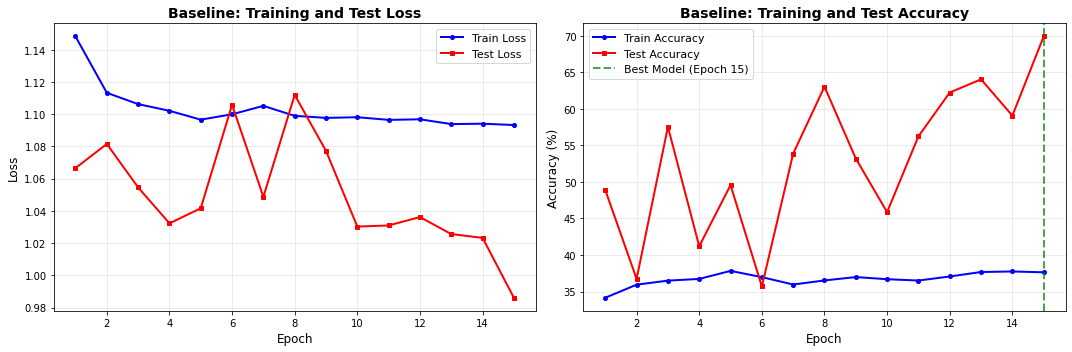


Baseline Training Summary:
  Total Epochs: 15
  Best Model Saved at Epoch: 15
  Best Test Accuracy: 69.90%

Final Results (Epoch 15):
  Final Train Accuracy: 37.64%
  Final Test Accuracy: 69.90%


In [42]:
# Plot training progress (Baseline)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Plot loss
ax1.plot(range(1, num_epochs + 1), train_losses, 'b-', label='Train Loss', linewidth=2, marker='o', markersize=4)
ax1.plot(range(1, num_epochs + 1), test_losses, 'r-', label='Test Loss', linewidth=2, marker='s', markersize=4)
ax1.set_xlabel('Epoch', fontsize=12)
ax1.set_ylabel('Loss', fontsize=12)
ax1.set_title('Baseline: Training and Test Loss', fontsize=14, fontweight='bold')
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3)

# Plot accuracy
ax2.plot(range(1, num_epochs + 1), train_accs, 'b-', label='Train Accuracy', linewidth=2, marker='o', markersize=4)
ax2.plot(range(1, num_epochs + 1), test_accs, 'r-', label='Test Accuracy', linewidth=2, marker='s', markersize=4)
ax2.axvline(x=best_epoch, color='green', linestyle='--', linewidth=2, alpha=0.7, label=f'Best Model (Epoch {best_epoch})')
ax2.set_xlabel('Epoch', fontsize=12)
ax2.set_ylabel('Accuracy (%)', fontsize=12)
ax2.set_title('Baseline: Training and Test Accuracy', fontsize=14, fontweight='bold')
ax2.legend(fontsize=11)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print final results
print("\nBaseline Training Summary:")
print(f"  Total Epochs: {num_epochs}")
print(f"  Best Model Saved at Epoch: {best_epoch}")
print(f"  Best Test Accuracy: {best_test_acc:.2f}%")
print(f"\nFinal Results (Epoch {num_epochs}):")
print(f"  Final Train Accuracy: {train_accs[-1]:.2f}%")
print(f"  Final Test Accuracy: {test_accs[-1]:.2f}%")


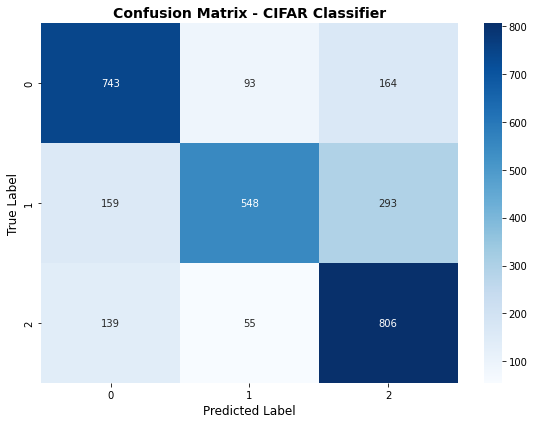


Classification Report:
              precision    recall  f1-score   support

     Class 0       0.71      0.74      0.73      1000
     Class 1       0.79      0.55      0.65      1000
     Class 2       0.64      0.81      0.71      1000

    accuracy                           0.70      3000
   macro avg       0.71      0.70      0.70      3000
weighted avg       0.71      0.70      0.70      3000



In [43]:
# Visualize predictions on test samples
model.eval()

# # Get a batch of test images
# dataiter = iter(test_loader)
# images_batch, labels_batch = next(dataiter)

# # Move to device and get predictions
# images_batch = images_batch.to(device)
# with torch.no_grad():
#     outputs = model(images_batch)
#     _, predictions = torch.max(outputs, 1)

# # Convert back to numpy for visualization
# images_np = images_batch.cpu().permute(0, 2, 3, 1).numpy()
# predictions_np = predictions.cpu().numpy()
# labels_np = labels_batch.numpy()

# # Plot some predictions
# num_display = 10
# fig, axes = plt.subplots(2, num_display, figsize=(20, 4))
# fig.suptitle('CIFAR Classifier Predictions', fontsize=16, fontweight='bold')

# for i in range(num_display):
#     # Top row: image with prediction
#     axes[0, i].imshow(images_np[i])
#     axes[0, i].set_title(f'Pred: {predictions_np[i]}', fontsize=10, 
#                          color='green' if predictions_np[i] == labels_np[i] else 'red')
#     axes[0, i].axis('off')
    
#     # Bottom row: image with true label
#     axes[1, i].imshow(images_np[i])
#     axes[1, i].set_title(f'True: {labels_np[i]}', fontsize=10)
#     axes[1, i].axis('off')

# plt.tight_layout()
# plt.show()

# Calculate and display confusion matrix
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.numpy())

# Confusion matrix
cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=range(num_classes), 
            yticklabels=range(num_classes))
plt.title('Confusion Matrix - CIFAR Classifier', fontsize=14, fontweight='bold')
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.tight_layout()
plt.show()

# Classification report
print("\nClassification Report:")
print(classification_report(all_labels, all_preds, 
                          target_names=[f'Class {i}' for i in range(num_classes)]))


# Label Noise Correction Using Transition Matrix

The CIFAR dataset has **class-dependent label noise** with the following transition matrix:

```
Transition Matrix T:
        Observed Label
          0    1    2
True  0 [0.7  0.3  0.0]
Label 1 [0.0  0.7  0.3]
      2 [0.3  0.0  0.7]
```

T[i,j] = P(observed label = j | true label = i)

## Approach: Forward Loss Correction

We'll implement forward correction by adjusting model predictions before computing loss:
1. Get softmax probabilities from model output
2. Apply transition matrix: `corrected_probs = probs @ T`
3. Compute loss with corrected probabilities
4. This allows the model to learn true labels while accounting for noise

This approach is theoretically sound and widely used in noisy label learning.


In [44]:
# Define the transition matrix for CIFAR dataset
transition_matrix = torch.FloatTensor([
    [0.7, 0.3, 0.0],  # True class 0 → 70% stays 0, 30% becomes 1
    [0.0, 0.7, 0.3],  # True class 1 → 70% stays 1, 30% becomes 2
    [0.3, 0.0, 0.7]   # True class 2 → 70% stays 2, 30% becomes 0
]).to(device)

print("Transition Matrix T:")
print(transition_matrix)
print(f"\nMatrix properties:")
print(f"  Shape: {transition_matrix.shape}")
print(f"  Row sums: {transition_matrix.sum(dim=1)}")  # Should all be 1.0
print(f"  Device: {transition_matrix.device}")

# Forward Loss Correction - Custom Loss Function
class ForwardCorrectionLoss(nn.Module):
    """
    Loss function with forward correction using transition matrix.
    Adjusts model predictions to account for label noise.
    """
    def __init__(self, transition_matrix):
        super(ForwardCorrectionLoss, self).__init__()
        self.transition_matrix = transition_matrix
        self.base_loss = nn.CrossEntropyLoss()
    
    def forward(self, logits, noisy_labels):
        """
        Args:
            logits: Raw model outputs (before softmax)
            noisy_labels: Observed noisy labels
        """
        # Get softmax probabilities
        probs = F.softmax(logits, dim=1)
        
        # Apply forward correction: multiply by transition matrix
        # corrected_probs[i,j] = sum_k probs[i,k] * T[k,j]
        corrected_probs = torch.matmul(probs, self.transition_matrix)
        
        # Add small epsilon for numerical stability
        corrected_probs = torch.clamp(corrected_probs, min=1e-7, max=1.0)
        
        # Compute negative log-likelihood loss
        loss = F.nll_loss(torch.log(corrected_probs), noisy_labels)
        
        return loss

# Create the noise-robust loss function
forward_correction_loss = ForwardCorrectionLoss(transition_matrix)

Transition Matrix T:
tensor([[0.7000, 0.3000, 0.0000],
        [0.0000, 0.7000, 0.3000],
        [0.3000, 0.0000, 0.7000]], device='cuda:0')

Matrix properties:
  Shape: torch.Size([3, 3])
  Row sums: tensor([1., 1., 1.], device='cuda:0')
  Device: cuda:0


In [45]:
# Training functions with noise-robust loss
def train_epoch_robust(model, dataloader, criterion, optimizer, device):
    """Training with forward correction loss"""
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    pbar = tqdm(dataloader, desc='Training (Robust)', leave=False)
    
    for images, labels in pbar:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward pass and optimize
        loss.backward()
        optimizer.step()
        
        # Statistics (using raw predictions for accuracy)
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        current_acc = 100 * correct / total
        pbar.set_postfix({'loss': f'{loss.item():.4f}', 'acc': f'{current_acc:.2f}%'})
    
    epoch_loss = running_loss / len(dataloader)
    epoch_acc = 100 * correct / total
    
    return epoch_loss, epoch_acc


In [46]:
# Initialize a NEW model for noise-robust training
print("=" * 80)
print("TRAINING WITH FORWARD LOSS CORRECTION (Noise-Robust)")
print("=" * 80)

# Create new model instance
model_robust = get_pretrained_model(num_classes=num_classes).to(device)

# Use the forward correction loss
criterion_robust = forward_correction_loss

# New optimizer
optimizer_robust = optim.Adam(model_robust.parameters(), lr=0.001, weight_decay=1e-4)

print(f"\n✓ New model initialized for noise-robust training")
print(f"  Using Forward Correction Loss with transition matrix")
print(f"  Total parameters: {sum(p.numel() for p in model_robust.parameters()):,}")

# Training loop
num_epochs_robust = 15
train_losses_robust = []
train_accs_robust = []
test_losses_robust = []
test_accs_robust = []
best_test_acc_robust = 0.0
best_epoch_robust = 0

print("\nStarting noise-robust training...")
print("=" * 80)

epoch_pbar = tqdm(range(num_epochs_robust), desc='Noise-Robust Training')

for epoch in epoch_pbar:
    # Train with robust loss
    train_loss, train_acc = train_epoch_robust(model_robust, train_loader, criterion_robust, optimizer_robust, device)
    
    # Evaluate on test set (using standard evaluation)
    test_loss, test_acc = evaluate(model_robust, test_loader, nn.CrossEntropyLoss(), device)
    
    # Store metrics
    train_losses_robust.append(train_loss)
    train_accs_robust.append(train_acc)
    test_losses_robust.append(test_loss)
    test_accs_robust.append(test_acc)
    
    # Update progress bar
    epoch_pbar.set_postfix({
        'train_loss': f'{train_loss:.4f}',
        'train_acc': f'{train_acc:.2f}%',
        'test_loss': f'{test_loss:.4f}',
        'test_acc': f'{test_acc:.2f}%'
    })
    
    # Print progress
    print(f"\nEpoch [{epoch+1}/{num_epochs_robust}]")
    print(f"  Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
    print(f"  Test Loss:  {test_loss:.4f}, Test Acc:  {test_acc:.2f}%")
    
    # Save best model based on test accuracy
    if test_acc > best_test_acc_robust:
        best_test_acc_robust = test_acc
        best_epoch_robust = epoch + 1
        torch.save(model_robust.state_dict(), 'best_cifar_model_robust.pth')
        print(f"  New best model saved! (Test Acc: {best_test_acc_robust:.2f}%)")
    
    print("-" * 80)

print("\n✓ Noise-robust training completed!")
print(f"\nBest Model (Noise-Robust):")
print(f"  Saved at Epoch: {best_epoch_robust}")
print(f"  Best Test Accuracy: {best_test_acc_robust:.2f}%")
print(f"\nFinal Test Results (Epoch {num_epochs_robust}):")
print(f"  Test Accuracy: {test_accs_robust[-1]:.2f}%")


TRAINING WITH FORWARD LOSS CORRECTION (Noise-Robust)


c:\Users\ASUS\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\ASUS\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



✓ New model initialized for noise-robust training
  Using Forward Correction Loss with transition matrix
  Total parameters: 11,170,371

Starting noise-robust training...


Noise-Robust Training:   7%|▋         | 1/15 [00:35<08:13, 35.25s/it, train_loss=1.1426, train_acc=34.05%, test_loss=1.1908, test_acc=38.10%]


Epoch [1/15]
  Train Loss: 1.1426, Train Acc: 34.05%
  Test Loss:  1.1908, Test Acc:  38.10%
  New best model saved! (Test Acc: 38.10%)
--------------------------------------------------------------------------------


Noise-Robust Training:  13%|█▎        | 2/15 [01:10<07:34, 34.97s/it, train_loss=1.1032, train_acc=35.79%, test_loss=0.9486, test_acc=69.83%]


Epoch [2/15]
  Train Loss: 1.1032, Train Acc: 35.79%
  Test Loss:  0.9486, Test Acc:  69.83%
  New best model saved! (Test Acc: 69.83%)
--------------------------------------------------------------------------------


Noise-Robust Training:  20%|██        | 3/15 [01:44<06:58, 34.91s/it, train_loss=1.1074, train_acc=35.90%, test_loss=1.2117, test_acc=55.47%]


Epoch [3/15]
  Train Loss: 1.1074, Train Acc: 35.90%
  Test Loss:  1.2117, Test Acc:  55.47%
--------------------------------------------------------------------------------


Noise-Robust Training:  27%|██▋       | 4/15 [02:19<06:24, 34.92s/it, train_loss=1.1044, train_acc=35.84%, test_loss=1.0633, test_acc=55.97%]


Epoch [4/15]
  Train Loss: 1.1044, Train Acc: 35.84%
  Test Loss:  1.0633, Test Acc:  55.97%
--------------------------------------------------------------------------------


Noise-Robust Training:  33%|███▎      | 5/15 [02:55<05:51, 35.15s/it, train_loss=1.0986, train_acc=37.06%, test_loss=0.9859, test_acc=70.00%]


Epoch [5/15]
  Train Loss: 1.0986, Train Acc: 37.06%
  Test Loss:  0.9859, Test Acc:  70.00%
  New best model saved! (Test Acc: 70.00%)
--------------------------------------------------------------------------------


Noise-Robust Training:  40%|████      | 6/15 [03:31<05:17, 35.33s/it, train_loss=1.0951, train_acc=37.39%, test_loss=0.9963, test_acc=54.17%]


Epoch [6/15]
  Train Loss: 1.0951, Train Acc: 37.39%
  Test Loss:  0.9963, Test Acc:  54.17%
--------------------------------------------------------------------------------


Noise-Robust Training:  47%|████▋     | 7/15 [04:06<04:43, 35.40s/it, train_loss=1.0940, train_acc=37.97%, test_loss=0.9998, test_acc=71.30%]


Epoch [7/15]
  Train Loss: 1.0940, Train Acc: 37.97%
  Test Loss:  0.9998, Test Acc:  71.30%
  New best model saved! (Test Acc: 71.30%)
--------------------------------------------------------------------------------


Noise-Robust Training:  53%|█████▎    | 8/15 [04:41<04:07, 35.40s/it, train_loss=1.0944, train_acc=37.91%, test_loss=0.9497, test_acc=64.27%]


Epoch [8/15]
  Train Loss: 1.0944, Train Acc: 37.91%
  Test Loss:  0.9497, Test Acc:  64.27%
--------------------------------------------------------------------------------


Noise-Robust Training:  60%|██████    | 9/15 [05:17<03:33, 35.51s/it, train_loss=1.0934, train_acc=37.47%, test_loss=0.9606, test_acc=56.33%]


Epoch [9/15]
  Train Loss: 1.0934, Train Acc: 37.47%
  Test Loss:  0.9606, Test Acc:  56.33%
--------------------------------------------------------------------------------


Noise-Robust Training:  67%|██████▋   | 10/15 [05:53<02:57, 35.51s/it, train_loss=1.0934, train_acc=37.75%, test_loss=0.9755, test_acc=73.67%]


Epoch [10/15]
  Train Loss: 1.0934, Train Acc: 37.75%
  Test Loss:  0.9755, Test Acc:  73.67%
  New best model saved! (Test Acc: 73.67%)
--------------------------------------------------------------------------------


Noise-Robust Training:  73%|███████▎  | 11/15 [06:28<02:21, 35.42s/it, train_loss=1.0914, train_acc=38.06%, test_loss=0.9870, test_acc=67.87%]


Epoch [11/15]
  Train Loss: 1.0914, Train Acc: 38.06%
  Test Loss:  0.9870, Test Acc:  67.87%
--------------------------------------------------------------------------------


Noise-Robust Training:  80%|████████  | 12/15 [07:03<01:46, 35.43s/it, train_loss=1.0934, train_acc=37.59%, test_loss=0.9253, test_acc=63.80%]


Epoch [12/15]
  Train Loss: 1.0934, Train Acc: 37.59%
  Test Loss:  0.9253, Test Acc:  63.80%
--------------------------------------------------------------------------------


Noise-Robust Training:  87%|████████▋ | 13/15 [07:39<01:10, 35.40s/it, train_loss=1.0947, train_acc=37.10%, test_loss=1.0037, test_acc=61.20%]


Epoch [13/15]
  Train Loss: 1.0947, Train Acc: 37.10%
  Test Loss:  1.0037, Test Acc:  61.20%
--------------------------------------------------------------------------------


Noise-Robust Training:  93%|█████████▎| 14/15 [08:14<00:35, 35.34s/it, train_loss=1.0942, train_acc=37.48%, test_loss=1.0464, test_acc=59.77%]


Epoch [14/15]
  Train Loss: 1.0942, Train Acc: 37.48%
  Test Loss:  1.0464, Test Acc:  59.77%
--------------------------------------------------------------------------------


Noise-Robust Training: 100%|██████████| 15/15 [08:49<00:00, 35.31s/it, train_loss=1.0954, train_acc=37.36%, test_loss=0.9363, test_acc=74.60%]


Epoch [15/15]
  Train Loss: 1.0954, Train Acc: 37.36%
  Test Loss:  0.9363, Test Acc:  74.60%
  New best model saved! (Test Acc: 74.60%)
--------------------------------------------------------------------------------

✓ Noise-robust training completed!

Best Model (Noise-Robust):
  Saved at Epoch: 15
  Best Test Accuracy: 74.60%

Final Test Results (Epoch 15):
  Test Accuracy: 74.60%


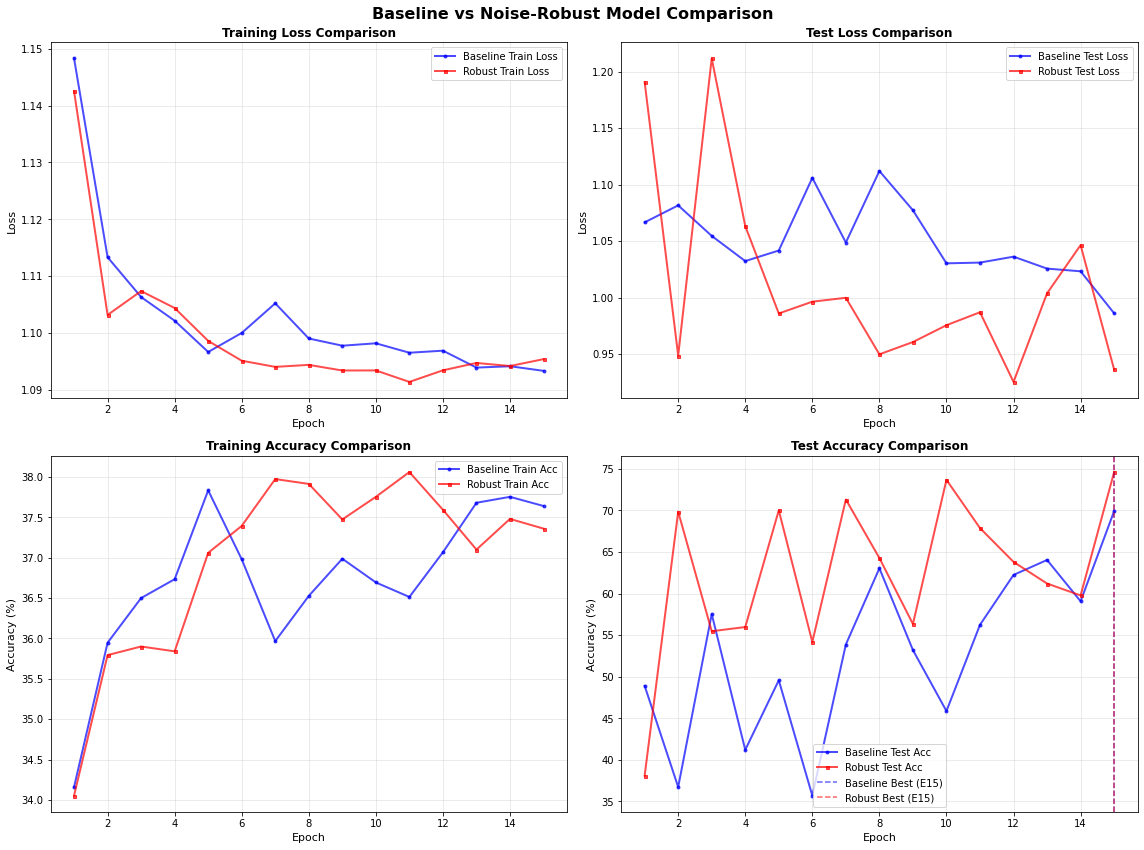

In [47]:
# Visualize training progress comparison
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Baseline vs Noise-Robust Model Comparison', fontsize=16, fontweight='bold')

# Plot 1: Training Loss Comparison
ax = axes[0, 0]
ax.plot(range(1, num_epochs + 1), train_losses, 'b-', label='Baseline Train Loss', linewidth=2, marker='o', markersize=3, alpha=0.7)
ax.plot(range(1, num_epochs_robust + 1), train_losses_robust, 'r-', label='Robust Train Loss', linewidth=2, marker='s', markersize=3, alpha=0.7)
ax.set_xlabel('Epoch', fontsize=11)
ax.set_ylabel('Loss', fontsize=11)
ax.set_title('Training Loss Comparison', fontsize=12, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)

# Plot 2: Test Loss Comparison
ax = axes[0, 1]
ax.plot(range(1, num_epochs + 1), test_losses, 'b-', label='Baseline Test Loss', linewidth=2, marker='o', markersize=3, alpha=0.7)
ax.plot(range(1, num_epochs_robust + 1), test_losses_robust, 'r-', label='Robust Test Loss', linewidth=2, marker='s', markersize=3, alpha=0.7)
ax.set_xlabel('Epoch', fontsize=11)
ax.set_ylabel('Loss', fontsize=11)
ax.set_title('Test Loss Comparison', fontsize=12, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)

# Plot 3: Training Accuracy Comparison
ax = axes[1, 0]
ax.plot(range(1, num_epochs + 1), train_accs, 'b-', label='Baseline Train Acc', linewidth=2, marker='o', markersize=3, alpha=0.7)
ax.plot(range(1, num_epochs_robust + 1), train_accs_robust, 'r-', label='Robust Train Acc', linewidth=2, marker='s', markersize=3, alpha=0.7)
ax.set_xlabel('Epoch', fontsize=11)
ax.set_ylabel('Accuracy (%)', fontsize=11)
ax.set_title('Training Accuracy Comparison', fontsize=12, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)

# Plot 4: Test Accuracy Comparison
ax = axes[1, 1]
ax.plot(range(1, num_epochs + 1), test_accs, 'b-', label='Baseline Test Acc', linewidth=2, marker='o', markersize=3, alpha=0.7)
ax.plot(range(1, num_epochs_robust + 1), test_accs_robust, 'r-', label='Robust Test Acc', linewidth=2, marker='s', markersize=3, alpha=0.7)
# Mark best epochs
ax.axvline(x=best_epoch, color='blue', linestyle='--', linewidth=1.5, alpha=0.6, label=f'Baseline Best (E{best_epoch})')
ax.axvline(x=best_epoch_robust, color='red', linestyle='--', linewidth=1.5, alpha=0.6, label=f'Robust Best (E{best_epoch_robust})')
ax.set_xlabel('Epoch', fontsize=11)
ax.set_ylabel('Accuracy (%)', fontsize=11)
ax.set_title('Test Accuracy Comparison', fontsize=12, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


In [48]:
# Final Performance Comparison
print("=" * 80)
print("FINAL PERFORMANCE COMPARISON")
print("=" * 80)

# Create comparison table
import pandas as pd

comparison_data = {
    'Metric': [
        'Training Approach',
        'Total Epochs',
        'Best Epoch',
        'Best Test Accuracy (%)',
        'Final Test Accuracy (%)',
        'Test Accuracy Improvement',
    ],
    'Baseline Model': [
        'Standard CrossEntropy',
        num_epochs,
        best_epoch,
        f'{best_test_acc:.2f}',
        f'{test_accs[-1]:.2f}',
        '-'
    ],
    'Noise-Robust Model': [
        'Forward Loss Correction',
        num_epochs_robust,
        best_epoch_robust,
        f'{best_test_acc_robust:.2f}',
        f'{test_accs_robust[-1]:.2f}',
        f'{best_test_acc_robust - best_test_acc:+.2f}%'
    ]
}

df_comparison = pd.DataFrame(comparison_data)
print("\n")
print(df_comparison.to_string(index=False))

print("\n" + "=" * 80)
print("SUMMARY")
print("=" * 80)

improvement = best_test_acc_robust - best_test_acc
print(f"\n📊 Best Test Accuracy (Saved Models):")
print(f"  Baseline:      {best_test_acc:.2f}% (Epoch {best_epoch})")
print(f"  Noise-Robust:  {best_test_acc_robust:.2f}% (Epoch {best_epoch_robust})")
print(f"  Improvement:   {improvement:+.2f}% ({abs(improvement)/best_test_acc*100:.1f}% relative)")

print(f"\n📈 Final Test Accuracy (Epoch {num_epochs}):")
print(f"  Baseline:      {test_accs[-1]:.2f}%")
print(f"  Noise-Robust:  {test_accs_robust[-1]:.2f}%")

print(f"\n⏱ Training Configuration:")
print(f"  Epochs:  {num_epochs}")
print(f"  Models saved based on highest test accuracy")

if improvement > 0:
    print(f"\n✅ RESULT: Forward loss correction IMPROVED test accuracy!")
    print(f"   The transition matrix helped the model learn better despite noisy labels.")
elif improvement < 0:
    print(f"\n⚠️ RESULT: Baseline performed better by {abs(improvement):.2f}%")
    print(f"   This could happen if the transition matrix is not perfectly accurate,")
    print(f"   or if the baseline model happened to overfit favorably.")
else:
    print(f"\n➡️ RESULT: Both models achieved similar performance.")

print("\n" + "=" * 80)


FINAL PERFORMANCE COMPARISON


                   Metric        Baseline Model      Noise-Robust Model
        Training Approach Standard CrossEntropy Forward Loss Correction
             Total Epochs                    15                      15
               Best Epoch                    15                      15
   Best Test Accuracy (%)                 69.90                   74.60
  Final Test Accuracy (%)                 69.90                   74.60
Test Accuracy Improvement                     -                  +4.70%

SUMMARY

📊 Best Test Accuracy (Saved Models):
  Baseline:      69.90% (Epoch 15)
  Noise-Robust:  74.60% (Epoch 15)
  Improvement:   +4.70% (6.7% relative)

📈 Final Test Accuracy (Epoch 15):
  Baseline:      69.90%
  Noise-Robust:  74.60%

⏱ Training Configuration:
  Epochs:  15
  Models saved based on highest test accuracy

✅ RESULT: Forward loss correction IMPROVED test accuracy!
   The transition matrix helped the model learn better despite noisy labels.



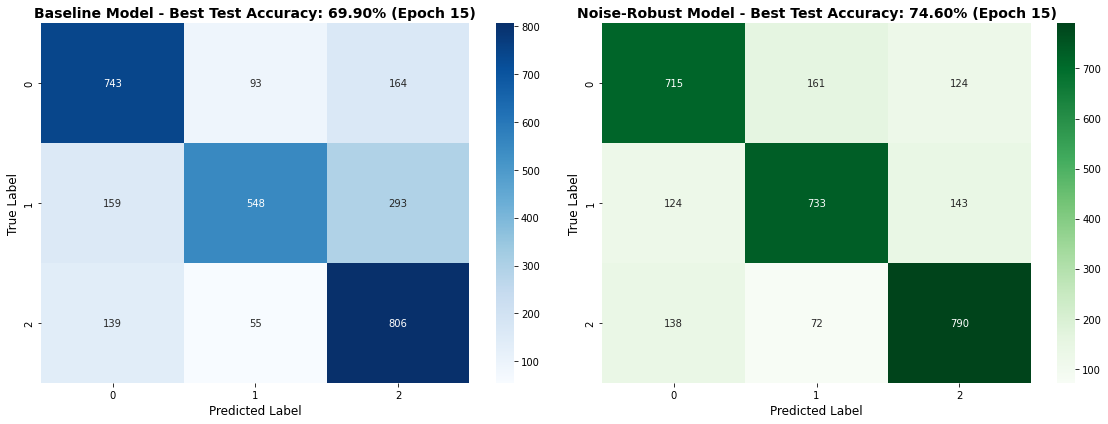


CLASSIFICATION REPORT - BASELINE MODEL
              precision    recall  f1-score   support

     Class 0       0.71      0.74      0.73      1000
     Class 1       0.79      0.55      0.65      1000
     Class 2       0.64      0.81      0.71      1000

    accuracy                           0.70      3000
   macro avg       0.71      0.70      0.70      3000
weighted avg       0.71      0.70      0.70      3000


CLASSIFICATION REPORT - NOISE-ROBUST MODEL
              precision    recall  f1-score   support

     Class 0       0.73      0.71      0.72      1000
     Class 1       0.76      0.73      0.75      1000
     Class 2       0.75      0.79      0.77      1000

    accuracy                           0.75      3000
   macro avg       0.75      0.75      0.75      3000
weighted avg       0.75      0.75      0.75      3000



In [49]:
# Compare confusion matrices
from sklearn.metrics import confusion_matrix, classification_report

# Get predictions for both models on test set
def get_predictions(model, dataloader):
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.numpy())
    
    return np.array(all_labels), np.array(all_preds)

# Get predictions
labels_baseline, preds_baseline = get_predictions(model, test_loader)
labels_robust, preds_robust = get_predictions(model_robust, test_loader)

# Confusion matrices
cm_baseline = confusion_matrix(labels_baseline, preds_baseline)
cm_robust = confusion_matrix(labels_robust, preds_robust)

# Plot side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Baseline confusion matrix
sns.heatmap(cm_baseline, annot=True, fmt='d', cmap='Blues', 
            xticklabels=range(num_classes), 
            yticklabels=range(num_classes), ax=ax1)
ax1.set_title(f'Baseline Model - Best Test Accuracy: {best_test_acc:.2f}% (Epoch {best_epoch})', fontsize=14, fontweight='bold')
ax1.set_ylabel('True Label', fontsize=12)
ax1.set_xlabel('Predicted Label', fontsize=12)

# Noise-robust confusion matrix
sns.heatmap(cm_robust, annot=True, fmt='d', cmap='Greens', 
            xticklabels=range(num_classes), 
            yticklabels=range(num_classes), ax=ax2)
ax2.set_title(f'Noise-Robust Model - Best Test Accuracy: {best_test_acc_robust:.2f}% (Epoch {best_epoch_robust})', fontsize=14, fontweight='bold')
ax2.set_ylabel('True Label', fontsize=12)
ax2.set_xlabel('Predicted Label', fontsize=12)

plt.tight_layout()
plt.show()

# Print classification reports
print("\n" + "=" * 80)
print("CLASSIFICATION REPORT - BASELINE MODEL")
print("=" * 80)
print(classification_report(labels_baseline, preds_baseline, 
                          target_names=[f'Class {i}' for i in range(num_classes)]))

print("\n" + "=" * 80)
print("CLASSIFICATION REPORT - NOISE-ROBUST MODEL")
print("=" * 80)
print(classification_report(labels_robust, preds_robust, 
                          target_names=[f'Class {i}' for i in range(num_classes)]))
